# Week 8 Practical: Model Selection Answers

This week we will revisit the Boston House Pricing data set and learn how to assess the fit of a model and construct a model that exhibits best performance on unseen data.

It is assumed that you have completed the previous practicals on data visualisation (week 6) and machine learning training (week 7).

So far we have learned to fit linear regression models to continuous target variables and logisitic regression models to discrete target variables. There are many other types of model that can be used. Today, we will investigate Decision Tree models. The techniques we use today are however independent of the specific model and can be applied to most other machine learning approaches. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve, ShuffleSplit
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from pydotplus import graph_from_dot_data
import matplotlib.pyplot as plt
from IPython.display import Image

sns.set_theme() # change theme so that we can see the axes grid in plots
sns.set(rc={'figure.figsize':(12,8)}) # change the default plot size 

# define a function for plotting a learning curve.
def plot_learning_curve(train_sizes, train_scores, test_scores, title=None, **kwargs):
    df_train = pd.DataFrame(train_scores).assign(dataset='Train',train_sizes=train_sizes)\
            .melt(id_vars=['dataset','train_sizes'], var_name='split', value_name='score')
    df_test = pd.DataFrame(test_scores).assign(dataset='Test',train_sizes=train_sizes)\
            .melt(id_vars=['dataset','train_sizes'], var_name='split', value_name='score')
    df = pd.concat([df_train,df_test]).reset_index(drop=True)
    plt.ylim(0, 1.02)
    g = sns.lineplot(data=df, x='train_sizes', y='score', hue='dataset', marker='o', **kwargs)
    if title is not None:
        g.set_title(title)

## 1. Decision Trees

Decision trees rely on a sequence of tests ("decisions") that determine what the prediction for a given sample should be. These rules can be organised in a tree structure, where each internal node in the tree represents a decision, and the outgoing edges represent the possible decision outcomes. The leaf nodes in the tree are associated the predictions of the decision tree.

Machine learning algorithms exist that can learn the structure, decisions, and outcomes in such a tree.

To understand how decision trees work, let us consider the question if we can predict if a passenger on the Titanic is likely to survive the disastrous encounter with an iceberg. There is a [well-known data set](https://www.kaggle.com/c/titanic) about the Titanic passengers that we could use for training such a model. In this dataset, each passenger is described by attributes, including *gender*, *age*, *number of siblings and spouses on board (sibsp)*, etc. You are free to explore the data set, but we will not consider it in detail in this practical.

Let's look at a Decision Tree that can be learned from this dataset:

![](https://upload.wikimedia.org/wikipedia/commons/e/eb/Decision_Tree.jpg)

We see that this tree includes 4 decision nodes and 4 leaf nodes. The first test that the decision tree would carry out on a given sample would be to assess if the passenger's *gender* was *male* or *female*. If *female*, the model would conclude that that passenger was likley to survive (leaf node labelled *survived*). Otherwise, the model would conduct another test based on *age*, and descend into the appropriate branch of the tree. Once a leaf node is reached, the model would output the associated outcome.

In the following, we will creat a Decision Tree to predict the type of flower on the IRIS data set we used last week.


## 2. Prepare the Dataset and Train a DT model

We begin by loading the data and creating train- and test sets. Retain all features, and reserve 30% of the samples as test set. 

In [2]:
iris = load_iris()
X = pd.DataFrame(iris['data'], columns=iris['feature_names'])
y = pd.DataFrame(iris['target'], columns=['class'])
iris_df = pd.concat([X,y],axis=1)

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(iris_df.drop(columns='class'), iris_df['class'], test_size = 0.3, random_state = 1234)

In [4]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((105, 4), (45, 4), (105,), (45,))

You obtain a training data set containing 105 samples and 4 features, and a test data set containing 45 samples.

Since we have already verified the split in a previous practical, we will skip that here.

Next, fit a [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to the training set. Use the default parameters of the classifier. 

In [5]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

DecisionTreeClassifier()

## 3. Assess the model

Assess the model in three ways:
1.  Compute a classification report on the TEST set
2.  Compute a classification report on the TRAINING set
3.  Visualise the Decision Tree

First, compute the classification report on the test set.

In [6]:
Y_pred_test = model.predict(X_test)
print(classification_report(Y_test, Y_pred_test, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        16
  versicolor       1.00      0.94      0.97        17
   virginica       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



We see that the results are a little worse than those obtained from the Logistic Regression model classifier we built last week.

Next, construct a classification report and test how well the model works on the training set.

In [7]:
Y_pred_train = model.predict(X_train)
print(classification_report(Y_train, Y_pred_train, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        34
  versicolor       1.00      1.00      1.00        33
   virginica       1.00      1.00      1.00        38

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



We learn that the classifier works very well on the training set. Indeed, it is perfect. That should raise alarm bells that something is wrong. We will investigate this shortly.

Before we do that, let's visualise the model tree so that we can understand what the model does.

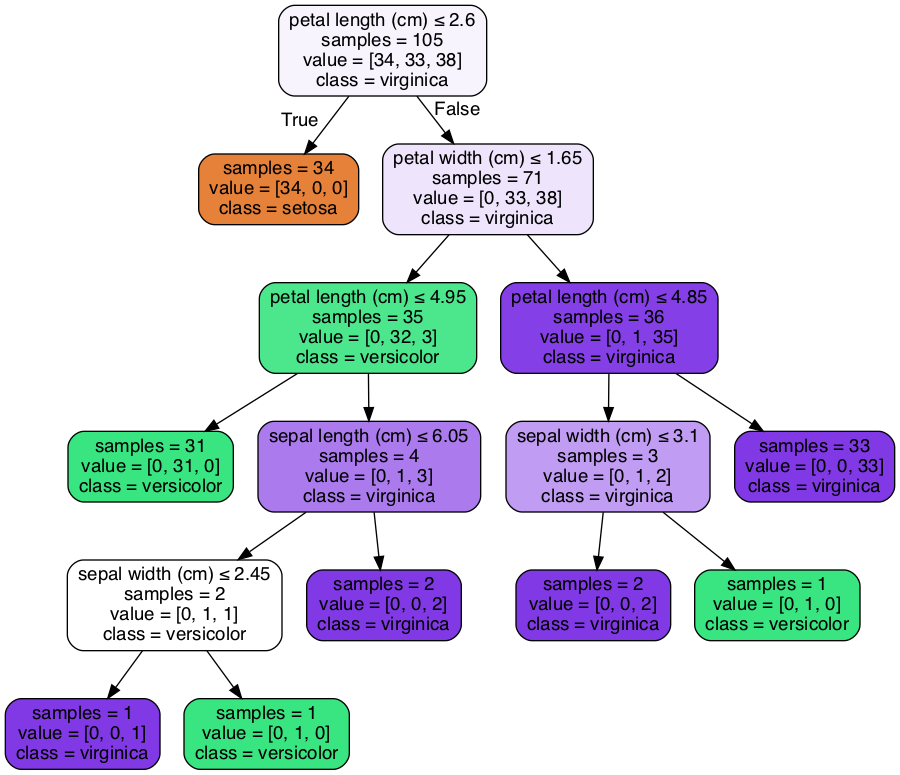

In [8]:
def plot_dt_model(model, feature_names, class_names):
    dot_data = export_graphviz(model, 
                            out_file=None, feature_names=feature_names, class_names=class_names,  
                            filled=True, rounded=True, impurity=False, special_characters=True)  
    graph = graph_from_dot_data(dot_data)  
    return Image(graph.create_png())
plot_dt_model(model, feature_names=iris.feature_names, class_names=iris.target_names)

In this plot, each interior node represents a decision, and each leaf node represents an output. For decision nodes, the first line in the node text represents the test that is performed. If the test is true, we follow the left branch below a node, otherwise, we follow the right branch. The `samples` entry shows how many of the predicted samples traverse this node. All of the 105 training samples traversed the root node, whereas only one sample ended up reaching the green node labelled `versicolor` on the right bottom of the tree. The `value` array shows the frequencies of the samples associated with each of the three classes. We can see that all interior nodes have non-zero frequencies for two or more classes, whereas the leaf nodes have non-zero values for one class. The `values` array gives an indiciation of the *purity* of the node. If there is only one class with non-zero frequency then the node is pure; otherwise, it is impure ("mixed").

Looking at this tree, we can see that it has learned quite a complex set of rules. Although *setosa* examples are easily distinguished from the other two classes by the test at the root node, quite a few tests are needed until a unique prediction, *virginica* or *versicolor*, is obtained on each path in the tree. If we examine the tree, we see that very few samples are associated with some of the leaf nodes. For example, there are several nodes that have only one or two samples associated with them. Having a decision tree that isolates individual samples (or very small groups of samples) can be a sign of overfitting, where the model represents the particular characteristics of the training data set instead of the true pattern that we wish to learn from the data.

As discussed in the lecture, we suspect that overfitting (high variance) has occurred if there is a significant difference between the resuls on the training set and on the test set. Here, the difference is rather small at 2% accuracy. (Whether 2% is significant or insignificant depends on the problem that is being solved.) However, the fact that the decision tree has isolated  individual samples suggests that it has overfitted the training set. In the following, we examine ways to mitigate the overfitting issue.

## 4. Improve the model

To improve the model, we will impose restrictions on the decision tree learning so that a simpler tree is obtained. There are two fundamental ways this can be done: (i) learn a complete tree and prune back the branches where the decisions leading to the leaf nodes do not add significantly to the overall performance of the tree, and (ii) stop growing the tree once conditions on size of the tree, purity of the nodes, or improvement gained from splitting are met. Scikit-learn implements the latter approach.

[`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) has a number of hyper-parameters that we can tune to achieve this:

* **max_depth:** restricts how deep the tree can grow. The value is an integer representing the maximum tree depth.
* **min_samples_leaf**: enforces that leaf nodes are associated with at least this many samples. If an integral value, this value represents the minimum count of samples in a leaf node. If a real number, the number represents the minimum fraction of all samples that must be associated with each leaf node.

Using these parameters, we can attempt to tune the decision tree so that it does not isolate individual examples in the training set. Thus, we can hope that the tree will not overfit to the training data as much.

Let's see how this works. Train another model, but this time pass `min_samples_leaf=5` to the constructor of the Decision Tree Classifier.

Then construct classification reports for train- and test set, and plot the tree.

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        16
  versicolor       0.94      0.94      0.94        17
   virginica       0.92      0.92      0.92        12

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        34
  versicolor       0.91      0.97      0.94        33
   virginica       0.97      0.92      0.95        38

    accuracy                           0.96       105
   macro avg       0.96      0.96      0.96       105
weighted avg       0.96      0.96      0.96       105



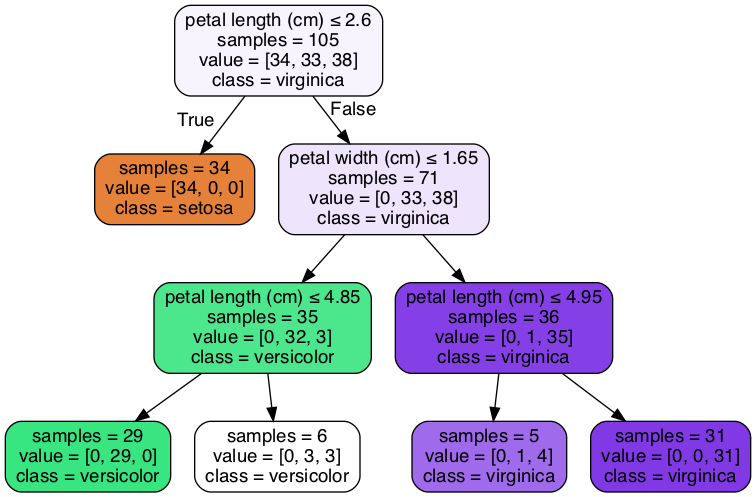

In [9]:
model = DecisionTreeClassifier(min_samples_leaf=5)
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
Y_pred_train = model.predict(X_train)
print(classification_report(Y_test, Y_pred_test, target_names=iris.target_names))
print(classification_report(Y_train, Y_pred_train, target_names=iris.target_names))
plot_dt_model(model, feature_names=iris.feature_names, class_names=iris.target_names)

We see that the tree is now much shallower; it has only 4 levels. Moreover, we see that the number of samples now exceeds the minimum of 5 that was imposed by us. As a result, the classification results on the training set have decreased compared to those we obtained earlier. This is expected, as the model can now no longer isolate individual samples in the training set. Comparing the results between training and testing set, we see that their results are now more similar: the reduced training set results closely match the test set results, and the 2% gap we observed earlier has disappeared.

Now, repeat the same process, but set `max_depth=1` this time. What do you observe? (Ignore some errors that may be displayed while computing the classification report. These may arise because the model does not output any results for one of the classes, which means that the F1 score cannot be computed.)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        16
  versicolor       0.00      0.00      0.00        17
   virginica       0.41      1.00      0.59        12

    accuracy                           0.62        45
   macro avg       0.47      0.67      0.53        45
weighted avg       0.47      0.62      0.51        45

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        34
  versicolor       0.00      0.00      0.00        33
   virginica       0.54      1.00      0.70        38

    accuracy                           0.69       105
   macro avg       0.51      0.67      0.57       105
weighted avg       0.52      0.69      0.58       105



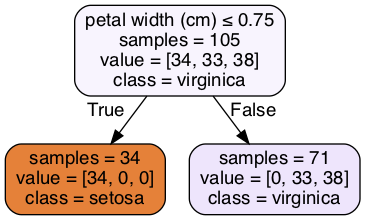

In [10]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
Y_pred_train = model.predict(X_train)
print(classification_report(Y_test, Y_pred_test, target_names=iris.target_names, zero_division=0))
print(classification_report(Y_train, Y_pred_train, target_names=iris.target_names, zero_division=0))
plot_dt_model(model, feature_names=iris.feature_names, class_names=iris.target_names)

We see that the results on the training set and the testing set have both declined considerably. For example, the model fails to correclty identify any of the samples belonging to class *versicolor*. The poor fit on the training set and the testing set indicates that the model was unable to learn the pattern that distinguishes the three classes of flower. This is an indication of underfitting (high bias). The model is too simple.

So how do we choose good values for the model so that it fits the data well, while not suffering from high bias and high variance issues?

To achieve this, we must construct different models, test each one, and then select a model that performs well enough. This process is called *model selection*.

When testing different models, which data sets should we use for trainging and testing the models? It is tempting to use the training set for training, and the testing set for testing the models. However tempting this approach may be, it is in general undesirable to select the best model in this way. What could be the reason for this? Think about the implications of using the test set of estimating how well each model performs, then using the test set results to pick the best model, and then using the test set to quantify how well the model may work on unseen ("out-of-sample") data. Would the last step yield useful results, or would this paint an overly optimistic picture of how well the model may work?

The answer is that using the test set for both selecting the best model and for assessing how well it works on out-of-sample data would likely over-estimate the model performance. This is because the test set data is no longer "unseen". We have already used it for model selection. At this point, the estimation we obtain from the test set is "biased" in that is may be higher than that we would obtain for a truly unseen data set. This is similar to the difference between assessing a model on the training set and assessing it on the test set, albeit not as pronounced. We would "overfit" to our test set.

If we cannot use the test set to select a model, then what shall we use? 

The answer is that we should use a separate data set, a "development data set", on which we test the models performance and use these results for model selection and optimisation. The test set remains reserved for the final testing of the best model we have selected. This way, we avoid biasing our estimation of the actual performance of the model.

Unfortunately, the IRIS data set has relatively few samples. If we reserve another signification portion of the data set for the development set, we risk that the number of samples remaining for training the models will be too small to yield good results (and the test set may then not be a representative sample of the overall data set). Hence, we shall use k-fold Cross-Validation (k-fold CV) instead.

The principle of k-fold CV is to partition the training data set into *k* partitions (randomly selected), then use *k-1* partitions to train the model and the *k*th partition to evaluate its performance. This process is repeated *k* times, each time using a different partition as the development set. The results of the *k* evaluations are averaged to yield an estimate of the performance. We can use this number to compare different models. The figure below illustrates this principle.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

We use CV using the function [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). We pass the model, the feature matrix, and the target values of the training set, along with the number of *cv* splits. 

Let's recreate the DT model where `min_samples_leaf=5`. Do not fit it to the data, as the cross_val_score will do this (repeatedly).
Then, invoke `cross_val_score` so that it will carry out 5-fold validation.

In [11]:
model = DecisionTreeClassifier(min_samples_leaf=5)
scores = cross_val_score(model, X_train, Y_train, cv=5)
scores

array([0.95238095, 0.95238095, 0.9047619 , 0.9047619 , 1.        ])

We should obtain 5 values, one for each fold. Most would be around 0.95, but there may be some diviations.

The scores represent the coefficient of variation, R2, which is a common measure for assessing the quality of a linear regression model. Values closer to 1.0 are better. (You could try pass a different scoring function to `cross_val_score` if you are interested in the MSE, for example.)

The mean value of these values is the estimated accuracy of our model.

In [12]:
scores.mean()

0.9428571428571427

We achieved 94% accuracy (your results may differ).

Now, let us use this to identify which value of `min_samples_leaf` yields best results.

Try to use different values  for `min_samples_leaf` and use CV to assess the model's mean result. Write a loop that tries values [1,2,3,4,5,6,7,8,9,10,15,20,30,50] and identify which model performs best. Store the mean score for each value in a list `scores`.

In [13]:
msl_values = [1,2,3,4,5,6,7,8,9,10,15,20,30,50]

In [14]:
scores = []
for msl in msl_values:
    model = DecisionTreeClassifier(min_samples_leaf=msl)
    score = cross_val_score(model, X_train, Y_train, cv=5).mean()
    scores.append(score)
print(scores)

[0.9428571428571428, 0.9619047619047618, 0.9714285714285715, 0.9619047619047618, 0.9523809523809523, 0.9523809523809523, 0.9523809523809523, 0.9619047619047618, 0.9523809523809523, 0.9523809523809523, 0.9428571428571428, 0.9428571428571428, 0.657142857142857, 0.36190476190476184]


We can visualise this data as a curve:

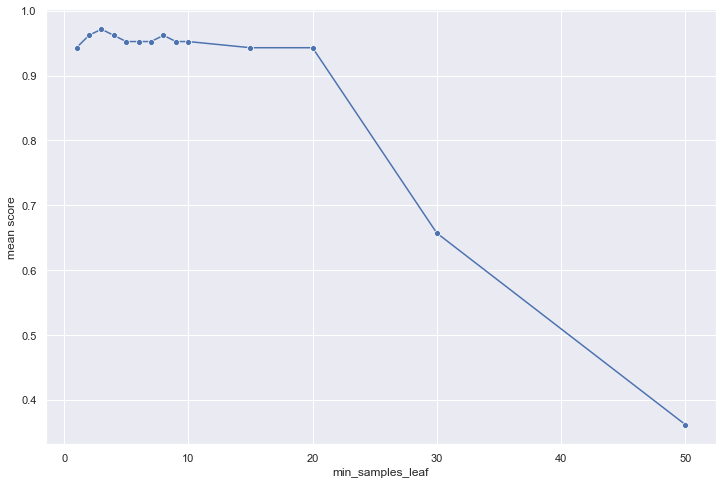

In [15]:
scores_df = pd.DataFrame.from_records(zip(msl_values,scores), columns=['min_samples_leaf','mean score'])
sns.lineplot(data=scores_df, x='min_samples_leaf', y='mean score', marker='o');

These results suggest that `min_samples_leaf=3` may work best. (Your results may differ.)

Let's fit a model to the entire training set using that parameter value, and test how well it performs on the test set.

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        16
  versicolor       1.00      0.94      0.97        17
   virginica       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        34
  versicolor       1.00      0.94      0.97        33
   virginica       0.95      1.00      0.97        38

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105



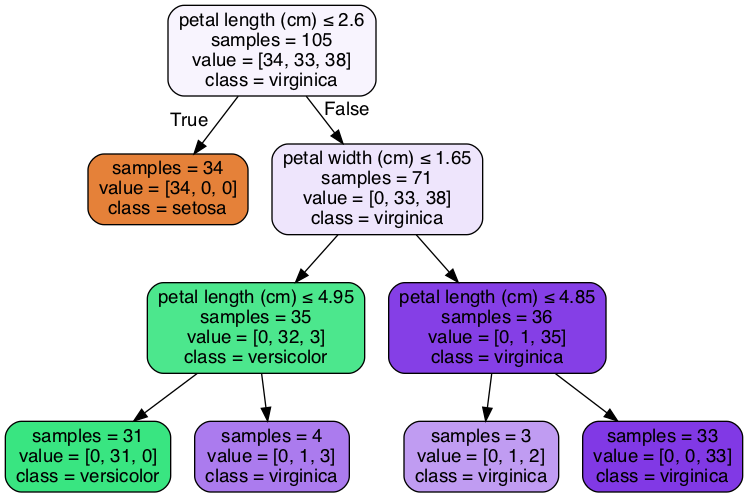

In [16]:
model = DecisionTreeClassifier(min_samples_leaf=3)
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
Y_pred_train = model.predict(X_train)
print(classification_report(Y_test, Y_pred_test, target_names=iris.target_names, zero_division=0))
print(classification_report(Y_train, Y_pred_train, target_names=iris.target_names, zero_division=0))
plot_dt_model(model, feature_names=iris.feature_names, class_names=iris.target_names)

We observe that the model is slightly more complex than what we obtained earlier (when we guessed a value for that hyper parameter). In return, we obtain slightly better results on the test set. Indeed, we see that the classification reports are essentially identical to the classification results we obtained using Logistic Regression in a previous practical. Moreover, the results on the training set, the test set, and the cross-validation scores are all clost to each other, which builds confidence that we have chosen a good value for this hyperparameter.

Although the above procedure is illustraive of how model selection with CV works, we can reduce the amount of code that we need to write to accomplish this.

Scikit-learn already provides us with the needed primitives: [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) performs systematic search for the best hyperparameter values and uses CV for scoring each candidate model. If we are seeking to tune multiple hyper-parameters at once this can simplify our work quite a bit.

GridSearchCV expects that we pass in a dict object that specifies the values that we wish to try for each of the hyperparameters that we wish to tune. In our case, there is only one. We pass `param_grid={'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,15,20,30,50]}` to achieve the desired effect. Once the best hyperparameter values have been found, grid search automatically fits a model using these parameters on the entire training set and returns it (provided that the default of `refit=True` is not altered). This best model is accessible via attribute `best_estimator_`, and the corresponding hyperparameter values are accessible via attribute `best_params_`.

Try to repeat the previous tuning experiment using [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). Remember to pass `cv=5` to ensure that Cross-Validation is used. You may switch on verbose reporting (`verbose=3`) to see what GridSearchCV is doing.

In [17]:
grid = GridSearchCV( DecisionTreeClassifier(), param_grid={'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,15,20,30,50]}, cv=5, verbose=3)
grid.fit(X_train, Y_train)
model = grid.best_estimator_
model, grid.best_params_

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ................min_samples_leaf=1;, score=1.000 total time=   0.0s
[CV 2/5] END ................min_samples_leaf=1;, score=1.000 total time=   0.0s
[CV 3/5] END ................min_samples_leaf=1;, score=0.905 total time=   0.0s
[CV 4/5] END ................min_samples_leaf=1;, score=0.952 total time=   0.0s
[CV 5/5] END ................min_samples_leaf=1;, score=1.000 total time=   0.0s
[CV 1/5] END ................min_samples_leaf=2;, score=1.000 total time=   0.0s
[CV 2/5] END ................min_samples_leaf=2;, score=1.000 total time=   0.0s
[CV 3/5] END ................min_samples_leaf=2;, score=0.905 total time=   0.0s
[CV 4/5] END ................min_samples_leaf=2;, score=0.952 total time=   0.0s
[CV 5/5] END ................min_samples_leaf=2;, score=0.952 total time=   0.0s
[CV 1/5] END ................min_samples_leaf=3;, score=1.000 total time=   0.0s
[CV 2/5] END ................min_samples_leaf=3;

(DecisionTreeClassifier(min_samples_leaf=3), {'min_samples_leaf': 3})

## 5. Revisit the Boston House Pricing Dataset

Next, revisit the Boston House Pricing dataset. In an earlier practical, we fitted a [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model and achieved a mean squared error of 32.74 when predicting target MEDV. In the following, we will try if we can improve upon that result by using a different model.

We will fit a [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) model, which is a variant of a decision tree where the leaf nodes are associated with a linear regression model instead of a discrete label for prediction. The particular form of tree regressor we will be using uses a constant (horizontal line) at each leaf node.

We begin by loading the dataset and preparing training set (80%) and testing set (20%). We will select the same features as last time: `RM` and `LSTAT`.

In [18]:
boston_housing = load_boston()
X = pd.DataFrame(boston_housing['data'], columns=boston_housing['feature_names'])
y = pd.DataFrame(boston_housing['target'], columns=['MEDV'])
boston_df = pd.concat([X,y],axis=1)

In [19]:
selected_features = ['RM','LSTAT']
X_train, X_test, Y_train, Y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=10)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((404, 2), (404, 1), (102, 2), (102, 1))

We obtained a training set with 404 samples (2 features) and a test set with 102 samples.

Then, we construct the decision tree regressor (use default settings) and fit the data.

In [20]:
model = DecisionTreeRegressor()
model.fit(X_train, Y_train)

DecisionTreeRegressor()

Once we have fitted the model, we evaluate the model on the training and testing set.

In [21]:
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

mean_squared_error(Y_train, Y_pred_train), mean_squared_error(Y_test, Y_pred_test)

(0.0, 52.28686274509805)

We see that the model predicts each training point perfectly, while it has an MSE of 52.29 on the test set. We may suspect that there is a high variance issue with this model. Moreover, the perfect score on the training set is immediately suspicious.

If this is indeed a high variance issue, we have several potential remedies to consider:
* Add more training data
* Reduce model complexity
* Reduce features (which indireclty also reduces model complexity).

How do we choose?

To investigate this further, let us visualise how the model is behaving as a function of the training samples. We vary the size of the training data set and see how that affects the training and testing error. We use function [`learning curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) to compute the scores for different sizes of train/test set and use 5-fold CV. We consider training set sizes of 10% to 95% in 5% increments. Store the result of the learning curve computation in variables `train_sizes`, `train_scores`, and `test_scores`.

In [22]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train, Y_train, cv=5, train_sizes=np.arange(0.1,0.95,0.05))

Plot the learning curve so that we can analyse how training set and test set metrics change.

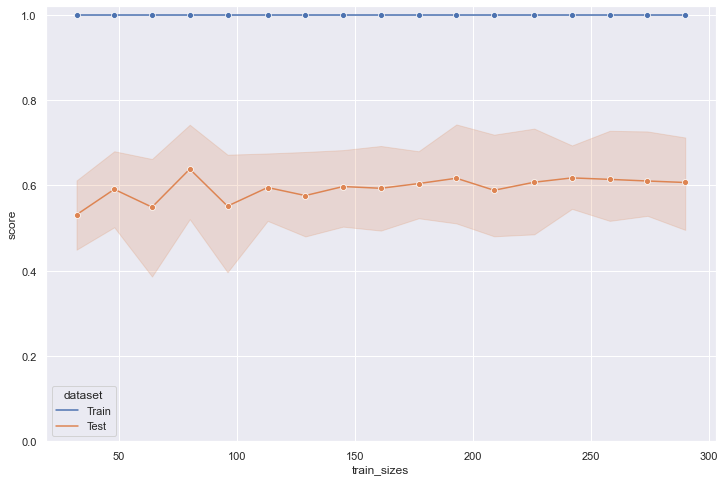

In [23]:
plot_learning_curve(train_sizes, train_scores, test_scores)

The learning curve for the DecisionTreeRegressor shows the coefficient of determination, R2, which indicates how much of the variation in the data is explained by the model. The closer to 1.0 the value is, the better. This is the default scoring function for the regressor.

From ~135 on, the test score flattens and does not improve further. This tells us that the gap between training and testing results cannot be narrowed by adding more training data. Therefore, we must look at other ways to fix the high variance issue.

Another way to address the high variance issue is to simplify the model so that it can no longer represent all the detail and noise in the training data. As in the IRIS classification model optimisation, the Decision Tree Regressor has a few hyperparameters that we can adjust.

Let us consider the effect of varying `max_depth`. Let us consider values 1, 2, 6, and 10.
Plot a learning curve for each value of `max_depth`.

What can you learn from each of the curves?

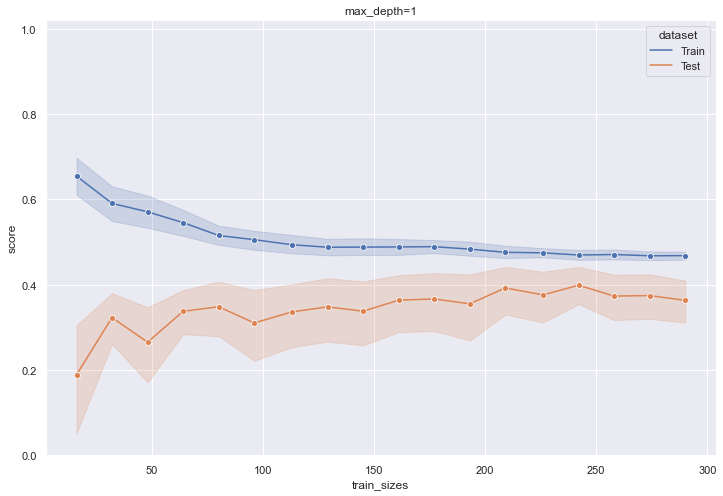

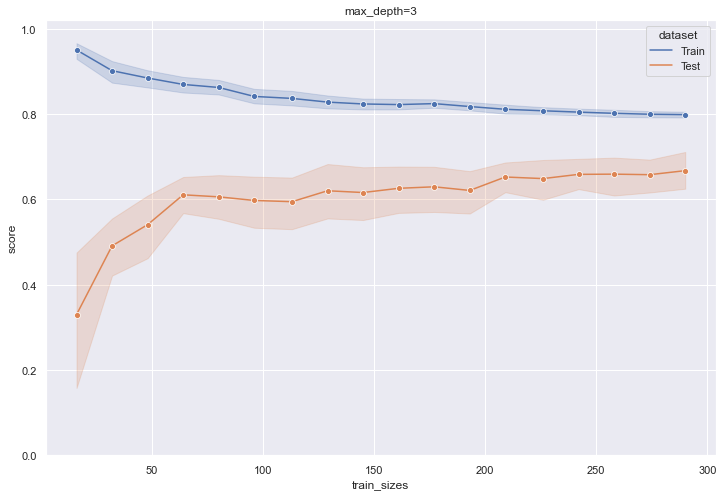

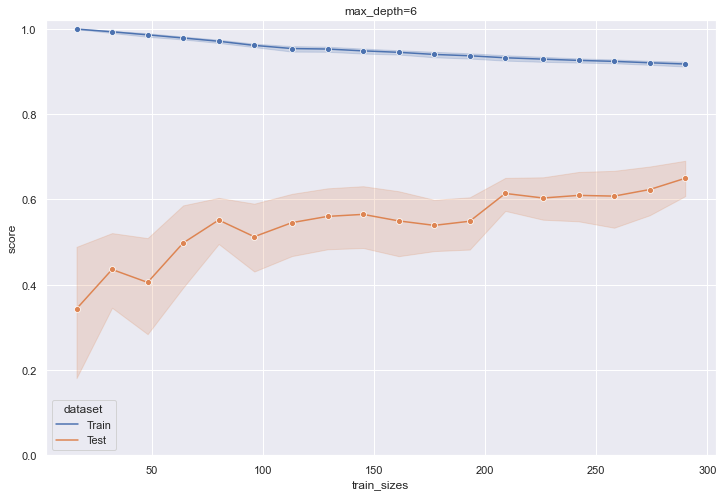

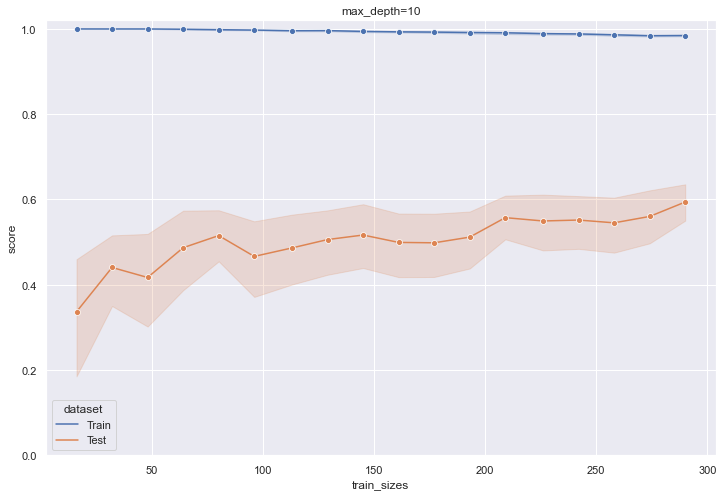

In [24]:
cv = ShuffleSplit(n_splits=20, test_size = 0.2, random_state = 1234)
for max_depth in [1,3,6,10]:
    model = DecisionTreeRegressor(max_depth=max_depth)
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, Y_train, cv=cv, train_sizes=np.arange(0.05,0.95,0.05))
    plot_learning_curve(train_sizes, train_scores, test_scores, title=f'max_depth={max_depth}')
    plt.show()

We learn that for `max_depth=1`, the training and test scores are both low. This indicates a high bias problem. This model has underfitted, it is too simple.

For `max_depth=3`, the training scores are somewhat lower, while the test scores have risen. There is a gap, however, it is not a huge difference. Among all the plots this is perhaps the best outcome.

For `max_depth=10`, the training scores are very high while the test scores are low. This is a clear case of overfitting (high variance).

For `max_depth=6`, the situation is similar, but less pronounced. This model has somewhat overfit the training data.

We conclude that the best model is the one where `max_depth=3`.

To corroborate this, let's visualise the score for each tree depth. Here, tree depth corresponds to model complexity, since a deeper tree can learn more detailed patterns.

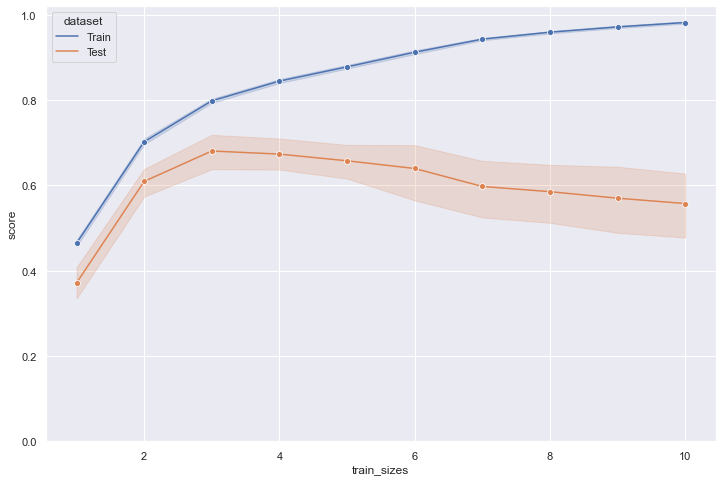

In [25]:
tree_depths=[1,2,3,4,5,6,7,8,9,10]
train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X_train, Y_train, 
                                             param_name="max_depth", param_range=tree_depths, cv=cv)
plot_learning_curve(tree_depths, train_scores, test_scores)

We can see that at tree depth 3, the model performance on the dev set peaks at about 0.7, then declines slowly. This corroborates our earlier finding that limiting the tree depth to 3 may be the optimal setting for the tree regressor. (Please ignore the mislabelled x-axis; this axis represents the maximum tree depth, not train_sizes, in this plot.)

Now, let us see if we can replicate this result using Grid Search CV.

In [26]:
grid = GridSearchCV( DecisionTreeRegressor(), param_grid={'max_depth':[1,2,3,4,5,6,7,8,9,10]}, cv=5)
grid.fit(X_train, Y_train)
model = grid.best_estimator_
model, grid.best_params_

(DecisionTreeRegressor(max_depth=3), {'max_depth': 3})

The depth that grid search finds matches our analysis.

Next, let's compute the mean squared error, and compare it to the error we obtained from the linear regression model in a previous practical.

In [27]:
Y_pred_test = model.predict(X_test)
mean_squared_error(Y_test, Y_pred_test)

47.52151871761335

We find that the MSE for our regression tree model is far worse than that of the linear model. Let's plot the predictions against the true MEDV values to see why that may be.

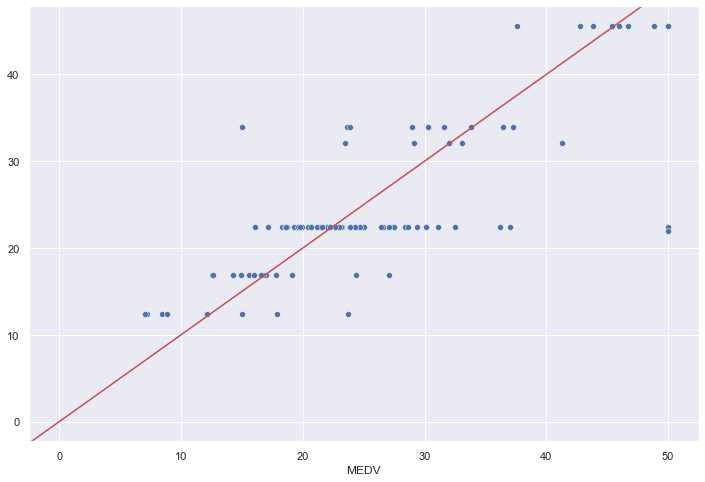

In [28]:
g = sns.scatterplot(x=Y_test['MEDV'], y=Y_pred_test)
g.axline(xy1=(0,0),slope=1, color='r');

We find that the decision tree regressor outputs only ~6 different values, as shown by the horizontal lines of marks on the plot. Thus, the regressor cannot capture the nuances of MEDV and suffers from relatively large error.

Finally, let's plot the tree regressor to see what it has learned:

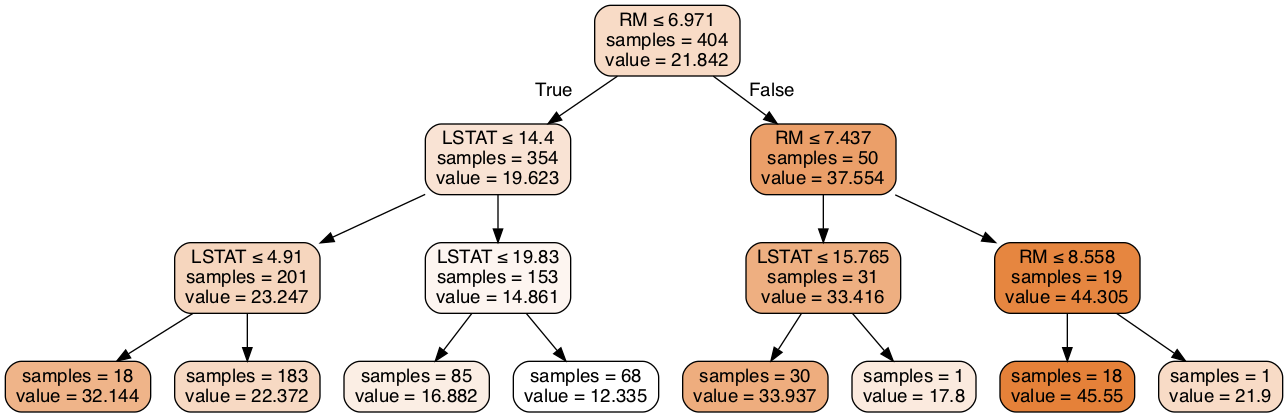

In [29]:
plot_dt_model(model, feature_names=selected_features, class_names=None)

We can see that there are indeed only 8 possible values in the tree (since each split has two alternatives, and there can be at most three splits on each path due to the depth restriction).

What now? We could try other models and transform the data so that some models may learn more easily. We would then use the same techniques that we have used today to select the best model among a pool of different models. Using a more advanced model and including additional features it is possible to reduce the MSE to ~0.11. However, that is beyond of the objectives of this practical.

Having completed this practical, you should be able to use grid search and k-fold crossvalidation to find optimal values for hyperparameters. You should also be able to visualise learning curves and validation curves to inspect a model's training profile, distinguish between high bias and high variance, and propose remedies to bias and variance issues. 

This concludes the practical.